In [1]:
%env CUDA_VISIBLE_DEVICES=1
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-04-17 01:57:35.480377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

from config import NUM_CLASSES

In [4]:
from dataset import Dataset

dataset = Dataset()

2023-04-17 01:57:39.981501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15363 MB memory:  -> device: 0, name: NVIDIA Tesla P100-SXM2-16GB, pci bus id: 0000:07:00.0, compute capability: 6.0


In [5]:
def reshape_dataset(x, y):
    x = tf.keras.layers.Reshape([32, -1])(x)
    # y_new = tf.keras.layers.Reshape([1, -1])(y)
    # return (x, y_new), y
    return x, y

train_dataset = dataset.get_training_set(
    batch_size=64,
    buffer_size=dataset.num_train_examples,
    repeat=False,
    deterministic=True,
    augmentation=False,
    pipeline="default")
train_dataset = train_dataset.map(reshape_dataset)

validation_dataset = dataset.get_validation_set(
    batch_size=64,
    pipeline="default")
validation_dataset = validation_dataset.map(reshape_dataset)

2023-04-17 01:57:40.642652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [1,?,?,2]
	 [[{{node Placeholder}}]]
2023-04-17 01:57:40.654698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [?,135,2]
	 [[{{node args_0}}]]
2023-04-17 01:57:40.817090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,?,2]
	 [[{{node Placeh

In [6]:
for examples, en_labels in train_dataset.take(1):
    pt = examples
    en = tf.keras.layers.Reshape([1, -1])(en_labels)
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

2023-04-17 01:57:40.860704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [32]
	 [[{{node Placeholder/_3}}]]
2023-04-17 01:57:40.861483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]


(64, 32, 270)
(64, 1, 250)
(64, 250)


In [7]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [8]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        # self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    # def compute_mask(self, *args, **kwargs):
    #     return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        # x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [9]:
embed_in = PositionalEmbedding(d_model=270)
embed_out = PositionalEmbedding(d_model=NUM_CLASSES)

pt_emb = embed_in(pt)
en_emb = embed_out(en)

pt_emb.shape, en_emb.shape

(TensorShape([64, 32, 270]), TensorShape([64, 1, 250]))

In [10]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [11]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [12]:
sample_ca = CrossAttention(num_heads=2, key_dim=270)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 32, 270)
(64, 1, 250)
(64, 1, 250)


2023-04-17 01:57:44.270569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


In [13]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [14]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=270)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 32, 270)
(64, 32, 270)


In [15]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        # attn_output = self.mha(
        #     query=x,
        #     value=x,
        #     key=x,
        #     use_causal_mask = True)
        # x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [16]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=270)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 1, 250)
(64, 1, 250)


In [17]:
out1 = sample_csa(embed_out(en[:, :3])) 
out2 = sample_csa(embed_out(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

0.0

In [18]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [19]:
sample_ffn = FeedForward(NUM_CLASSES, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 1, 250)
(64, 1, 250)


In [20]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [21]:
sample_encoder_layer = EncoderLayer(d_model=270, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 32, 270)
(64, 32, 270)


In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [23]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=270,
                         num_heads=8,
                         dff=2048)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 32, 270)
(64, 32, 270)


In [24]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [25]:
sample_decoder_layer = DecoderLayer(d_model=NUM_CLASSES, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 1, 250)
(64, 32, 270)
(64, 1, 250)


In [26]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    # x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [27]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=NUM_CLASSES,
                         num_heads=8,
                         dff=2048)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 1, 250)
(64, 32, 270)
(64, 1, 250)


In [28]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 1, 32])

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, num_classes,
               dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
    self.class_query = tf.Variable(tf.random.uniform(shape=[1, d_model]))
    # self.class_query_norm = tf.keras.layers.LayerNormalization()

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    # context, x  = inputs
    context = inputs
    
    x = tf.expand_dims(tf.repeat(self.class_query, tf.shape(context)[0], axis=0), axis=1)

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits[:, 0, :]

In [30]:
num_layers = 4
d_model = 270
dff = 2048
num_heads = 6
dropout_rate = 0.1

In [31]:
tf.random.set_seed(0)

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_classes=NUM_CLASSES,
    dropout_rate=dropout_rate)

In [32]:
# output = transformer((pt, en))
output = transformer(pt)

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 1, 250)
(64, 32, 270)
(64, 250)


In [33]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 6, 1, 32)


In [34]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  11456192  
                                                                 
 decoder_1 (Decoder)         multiple                  11458352  
                                                                 
 dense_38 (Dense)            multiple                  67750     
                                                                 
Total params: 22,982,564
Trainable params: 22,982,564
Non-trainable params: 0
_________________________________________________________________


In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [36]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

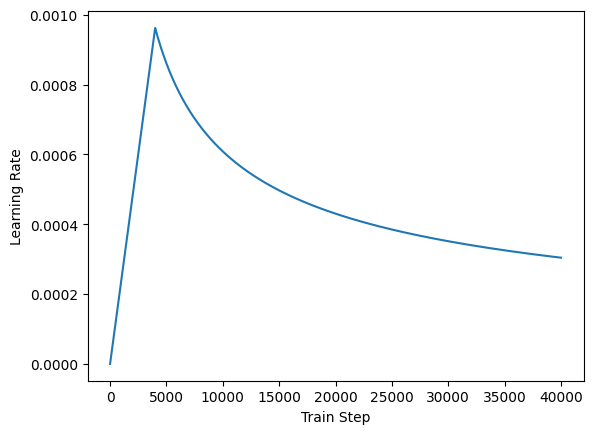

In [37]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [38]:
transformer.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1', dtype=tf.float32)])

In [39]:
transformer.fit(train_dataset,
                epochs=10,
                validation_data=validation_dataset)

Epoch 1/10


2023-04-17 01:57:46.529222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [32]
	 [[{{node Placeholder/_1}}]]
2023-04-17 01:57:46.529859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]
2023-04-17 01:58:00.838296: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3adc043a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-17 01:58:00.838369: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA Tesla P100

1181/1181 [==============================] - ETA: 0s - loss: 5.1127 - top_1: 0.0256

2023-04-17 01:59:34.763391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]
2023-04-17 01:59:34.764110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8]
	 [[{{node Placeholder/_2}}]]


1181/1181 [==============================] - 120s 78ms/step - loss: 5.1127 - top_1: 0.0256 - val_loss: 4.4158 - val_top_1: 0.0687
Epoch 2/10
1181/1181 [==============================] - 90s 76ms/step - loss: 4.3113 - top_1: 0.0823 - val_loss: 4.0269 - val_top_1: 0.1143
Epoch 3/10
1181/1181 [==============================] - 89s 76ms/step - loss: 4.1701 - top_1: 0.1015 - val_loss: 3.8132 - val_top_1: 0.1427
Epoch 4/10
1181/1181 [==============================] - 90s 76ms/step - loss: 4.2604 - top_1: 0.0957 - val_loss: 4.1460 - val_top_1: 0.1027
Epoch 5/10
1181/1181 [==============================] - 89s 76ms/step - loss: 4.0795 - top_1: 0.1177 - val_loss: 3.8439 - val_top_1: 0.1408
Epoch 6/10
1181/1181 [==============================] - 89s 76ms/step - loss: 3.9335 - top_1: 0.1378 - val_loss: 3.5632 - val_top_1: 0.1866
Epoch 7/10
1181/1181 [==============================] - 89s 75ms/step - loss: 3.7487 - top_1: 0.1623 - val_loss: 3.4162 - val_top_1: 0.2042
Epoch 8/10
1181/1181 [========

In [41]:
transformer.fit(train_dataset,
                epochs=10,
                validation_data=validation_dataset)

Epoch 1/10
1181/1181 [==============================] - 90s 76ms/step - loss: 3.2992 - top_1: 0.2351 - val_loss: 2.9904 - val_top_1: 0.2795
Epoch 2/10
1181/1181 [==============================] - 90s 76ms/step - loss: 3.2157 - top_1: 0.2474 - val_loss: 2.8974 - val_top_1: 0.3084
Epoch 3/10
1181/1181 [==============================] - 89s 76ms/step - loss: 3.1331 - top_1: 0.2626 - val_loss: 2.9372 - val_top_1: 0.3032
Epoch 4/10
1181/1181 [==============================] - 89s 76ms/step - loss: 3.0419 - top_1: 0.2780 - val_loss: 2.8667 - val_top_1: 0.3096
Epoch 5/10
1181/1181 [==============================] - 89s 76ms/step - loss: 2.9726 - top_1: 0.2920 - val_loss: 2.7918 - val_top_1: 0.3268
Epoch 6/10
1181/1181 [==============================] - 89s 75ms/step - loss: 2.8992 - top_1: 0.3040 - val_loss: 2.7445 - val_top_1: 0.3357
Epoch 7/10
1181/1181 [==============================] - 89s 75ms/step - loss: 2.8256 - top_1: 0.3176 - val_loss: 2.7756 - val_top_1: 0.3287
Epoch 8/10
1181/1181

In [40]:
transformer.evaluate(validation_dataset)

507/507 [==============================] - 10s 21ms/step - loss: 3.0473 - top_1: 0.2726


[3.0473270416259766, 0.27259737253189087]